In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # Ensures that the display width isn't restricted
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_csv('Network_anomaly_data.csv')
df.head()

,duration,protocoltype,service,flag,srcbytes,dstbytes,land,wrongfragment,urgent,hot,numfailedlogins,loggedin,numcompromised,rootshell,suattempted,numroot,numfilecreations,numshells,numaccessfiles,numoutboundcmds,ishostlogin,isguestlogin,count,srvcount,serrorrate,srvserrorrate,rerrorrate,srvrerrorrate,samesrvrate,diffsrvrate,srvdiffhostrate,dsthostcount,dsthostsrvcount,dsthostsamesrvrate,dsthostdiffsrvrate,dsthostsamesrcportrate,dsthostsrvdiffhostrate,dsthostserrorrate,dsthostsrvserrorrate,dsthostrerrorrate,dsthostsrvrerrorrate,attack,lastflag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [4]:
# land, wrongfragment,urgent, numfailedlogins,loggedin,rootshell,suattempted,numshells,ishostlogin,isguestlogin
df['land'] = df['land'].astype('category')
df['wrongfragment'] = df['wrongfragment'].astype('category')
df['urgent'] = df['urgent'].astype('category')
#df['numfailedlogins'] = df['numfailedlogins'].astype('category')
df['loggedin'] = df['loggedin'].astype('category')
df['rootshell'] = df['rootshell'].astype('category')
df['suattempted'] = df['suattempted'].astype('category')
df['numshells'] = df['numshells'].astype('category')
df['ishostlogin'] = df['ishostlogin'].astype('category')
df['isguestlogin'] = df['isguestlogin'].astype('category')

In [5]:
# Host count of flags
df['serror'] = df['count']*df['serrorrate']
df['rerror'] = df['count']*df['rerrorrate']

# Host srv count of flags
df['srvserror'] = df['srvcount']*df['srvrerrorrate']
df['srvrerror'] = df['srvcount']*df['srvserrorrate']

df['samesrv'] = df['count']*df['samesrvrate']
df['diffsrv'] = df['count']*df['diffsrvrate']

# Host count of flags
df['dsthostserror'] = df['dsthostcount']*df['dsthostserrorrate']
df['dsthostrerror'] = df['dsthostcount']*df['dsthostrerrorrate']

# Host srv count of flags
df['dsthostsrvserror'] = df['dsthostsrvcount']*df['dsthostsrvrerrorrate']
df['dsthostsrvrerror'] = df['dsthostsrvcount']*df['dsthostsrvserrorrate']

df['dsthostsamesrv'] = df['dsthostsrvcount']*df['dsthostsamesrvrate']
df['dsthostdiffsrv'] = df['dsthostsrvcount']*df['dsthostdiffsrvrate']

In [6]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
all_attacks = df['attack'].unique()

# Step 2: Create a stratified split ensuring that each category is in the test set at least once
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split the data by each attack category and ensure they appear in test
for category in all_attacks:
    category_data = df[df['attack'] == category]

    if len(category_data) > 30:
        category_train, category_test = train_test_split(category_data, test_size=0.2,random_state=42)

    elif len(category_data) == 1:
        test_data = pd.concat([test_data,category_data])
        noise_data = category_data.copy()
        noise_data['count'] += 0.0001
        train_data = pd.concat([train_data,noise_data],axis=0)
        continue

    elif len(category_data) > 1 and len(category_data) <= 5:
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,1)
        test_selection = category_data[~category_data.index.isin(chooser)]
        train_selection = category_data[category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])

        noise_data = train_selection.copy()
        noise_data['count'] += 0.0001
        train_data = pd.concat([train_data,noise_data],axis=0)
        continue
    
    elif len(category_data) > 5 and len(category_data) <= 10:
        #print('noise to',category)
        all_idx = category_data.index
        chooser = np.random.choice(all_idx,3)
        test_selection = category_data[category_data.index.isin(chooser)]
        train_selection = category_data[~category_data.index.isin(chooser)]

        test_data = pd.concat([test_data,test_selection])
        train_data = pd.concat([train_data,train_selection])
        continue
    

    else:
        category_train, category_test = train_test_split(category_data, test_size=0.3,random_state=42)
    
    # Append to the train and test sets
    train_data = pd.concat([train_data,category_train])
    test_data = pd.concat([test_data,category_test])

In [7]:
X_train = train_data.drop(['attack'],axis=1)
y_train = train_data['attack']
X_test = test_data.drop(['attack'],axis=1)
y_test = test_data['attack']

In [8]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

In [9]:
target_classes = [target_encoder.classes_[i] for i in range(len(target_encoder.classes_))]

In [10]:
acount = pd.DataFrame(train_data['attack'].value_counts().sort_values(ascending=True))
acount[acount['count'] < 40].index

Index(['perl', 'phf', 'spy', 'multihop', 'ftp_write', 'loadmodule', 'rootkit',
       'imap', 'land', 'warezmaster', 'buffer_overflow'],
      dtype='object', name='attack')

In [11]:
low_freq_attack = acount[acount['count'] < 40].index
ros_dict = dict()
smote_dict = dict()

for i in range(len(low_freq_attack)):
    sample_length = train_data[train_data['attack'] == low_freq_attack[i]].shape[0]
    if sample_length <= 8:
        ros_dict[target_classes.index(low_freq_attack[i])] = 8
    smote_dict[target_classes.index(low_freq_attack[i])] = 100

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

categorical_columns = ['protocoltype', 'service', 'flag','land','wrongfragment','urgent','loggedin','rootshell','suattempted','numshells',
                       'ishostlogin','isguestlogin']

encoder = LabelEncoder()
for col in categorical_columns:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])

In [13]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

ros = RandomOverSampler(sampling_strategy=ros_dict,random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train_encoded)

smote = SMOTE(sampling_strategy=smote_dict,random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_resampled, y_train_resampled)

In [14]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_smote[numerical_columns] = scaler.fit_transform(X_train_smote[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42,class_weight='balanced')
rf.fit(X_train_smote,y_train_smote)
y_pred = rf.predict(X_test)

<Axes: >

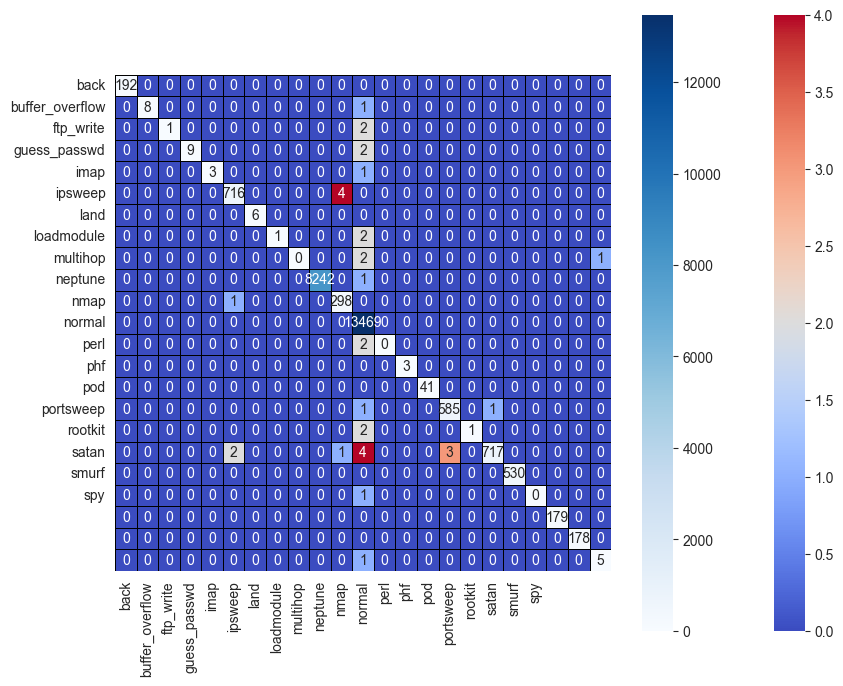

In [16]:
from sklearn.metrics import confusion_matrix

cmrf = confusion_matrix(y_test_encoded, y_pred)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmrf.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmrf, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmrf, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes[0:-3], yticklabels=target_classes[0:-3]) 

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test_encoded,y_pred,target_names=target_classes))

                 precision    recall  f1-score   support

           back       1.00      1.00      1.00       192
buffer_overflow       1.00      0.89      0.94         9
      ftp_write       1.00      0.33      0.50         3
   guess_passwd       1.00      0.82      0.90        11
           imap       1.00      0.75      0.86         4
        ipsweep       1.00      0.99      1.00       720
           land       1.00      1.00      1.00         6
     loadmodule       1.00      0.33      0.50         3
       multihop       0.00      0.00      0.00         3
        neptune       1.00      1.00      1.00      8243
           nmap       0.98      1.00      0.99       299
         normal       1.00      1.00      1.00     13469
           perl       0.00      0.00      0.00         2
            phf       1.00      1.00      1.00         3
            pod       1.00      1.00      1.00        41
      portsweep       0.99      1.00      1.00       587
        rootkit       1.00    

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [18]:
# from sklearn.model_selection import RandomizedSearchCV


# param_dist = {
#     'n_estimators': [100, 150,200,400],
#     'max_depth': [None, 10, 20,30,40],
#     'min_samples_split': [2, 5,7,10],
#     'max_features': ['sqrt', 'log2',None]
# }

# rf_model = RandomForestClassifier(random_state=42,class_weight='balanced')

# random_search_rf = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
#                                    n_iter=200, cv=5, scoring='accuracy', 
#                                    n_jobs=-1, random_state=42)
# random_search_rf.fit(X_train, y_train)
# random_search_rf.best_params_

In [19]:
# best_rf = random_search_rf.best_estimator_
# y_pred_rf_best = best_rf.predict(X_test)

# cmbestrf = confusion_matrix(y_test, y_pred_rf_best)

# cmap = sns.color_palette("coolwarm", as_cmap=True)
# mask = np.eye(cmbestrf.shape[0], dtype=bool)

# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cmbestrf, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
#             linecolor='black', linewidth=0.5,
#             xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# # Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
# sns.heatmap(cmbestrf, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
#             mask=~mask, linecolor='black', linewidth=0.5,
#             xticklabels=target_classes[0:-3], yticklabels=target_classes[0:-3]) 

In [22]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier(objective='multi:softmax',random_state=42)
xgb1.fit(X_train_smote,y_train_smote)

y_pred_xgb = xgb1.predict(X_test)

<Axes: >

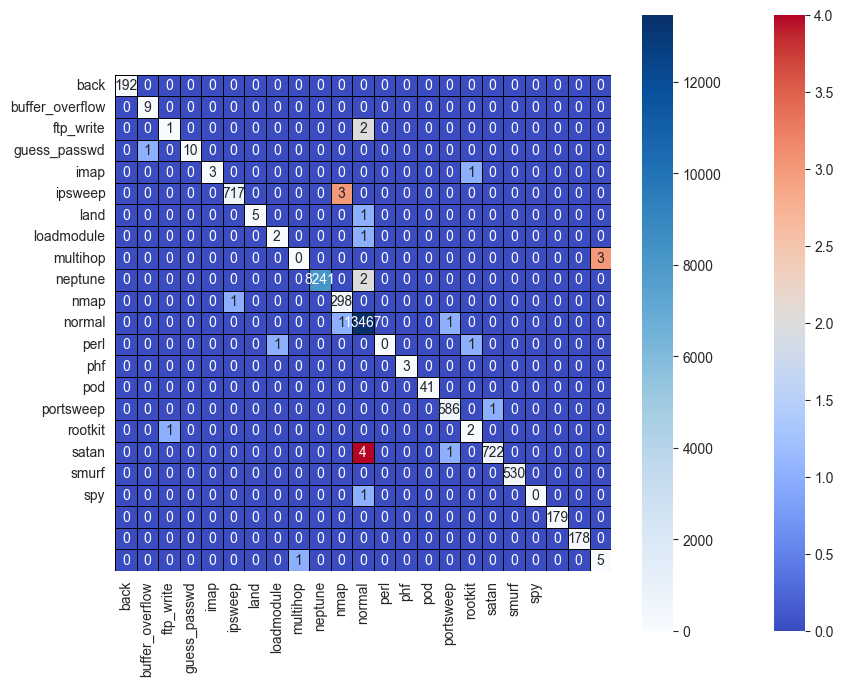

In [23]:
from sklearn.metrics import confusion_matrix

cmxgb = confusion_matrix(y_test_encoded, y_pred_xgb)


cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmxgb.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmxgb, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmxgb, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes[0:-3], yticklabels=target_classes[0:-3]) 

In [26]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test_encoded,y_pred_xgb,target_names=target_classes,output_dict=True)
pd.DataFrame(report_dict).T

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

,precision,recall,f1-score,support
back,1.000000,1.000000,1.000000,192.00000
buffer_overflow,0.900000,1.000000,0.947368,9.00000
ftp_write,0.500000,0.333333,0.400000,3.00000
guess_passwd,1.000000,0.909091,0.952381,11.00000
imap,1.000000,0.750000,0.857143,4.00000
ipsweep,0.998607,0.995833,0.997218,720.00000
land,1.000000,0.833333,0.909091,6.00000
loadmodule,0.666667,0.666667,0.666667,3.00000
multihop,0.000000,0.000000,0.000000,3.00000
neptune,1.000000,0.999757,0.999879,8243.00000


In [27]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier


param_dist = {
    'n_estimators': [50,100, 150,200],
    'max_depth': [3,4,5,7],
    "learning_rate": [0.1, 0.2, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb1 = XGBClassifier(objective='multi:softmax', num_class=len(target_classes),random_state=42)

random_search_xgb = RandomizedSearchCV(xgb1, param_distributions=param_dist, 
                                   n_iter=200, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search_xgb.fit(X_train_smote, y_train_smote)
random_search_xgb.best_params_

{'subsample': 0.8,
 'n_estimators': 150,
 'max_depth': 5,
 'learning_rate': 0.2,
 'colsample_bytree': 0.6}

In [1]:
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb_best = best_xgb.predict(X_test)

cmbestxgb = confusion_matrix(y_test_encoded, y_pred_xgb_best)

cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmbestxgb.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmbestxgb, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmbestxgb, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes) 

NameError: name 'random_search_xgb' is not defined

In [31]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_test_encoded,y_pred_xgb_best,target_names=target_classes,output_dict=True)
pd.DataFrame(report_dict).T

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

,precision,recall,f1-score,support
back,1.000000,1.000000,1.000000,192.000000
buffer_overflow,1.000000,1.000000,1.000000,9.000000
ftp_write,1.000000,0.333333,0.500000,3.000000
guess_passwd,1.000000,0.909091,0.952381,11.000000
imap,1.000000,0.750000,0.857143,4.000000
ipsweep,0.998605,0.994444,0.996521,720.000000
land,1.000000,1.000000,1.000000,6.000000
loadmodule,1.000000,0.666667,0.800000,3.000000
multihop,0.000000,0.000000,0.000000,3.000000
neptune,1.000000,0.999636,0.999818,8243.000000


In [32]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=42, loss = 'log_loss')
gbc.fit(X_train_smote, y_train_smote)
y_pred_gbc = gbc.predict(X_test)

<Axes: >

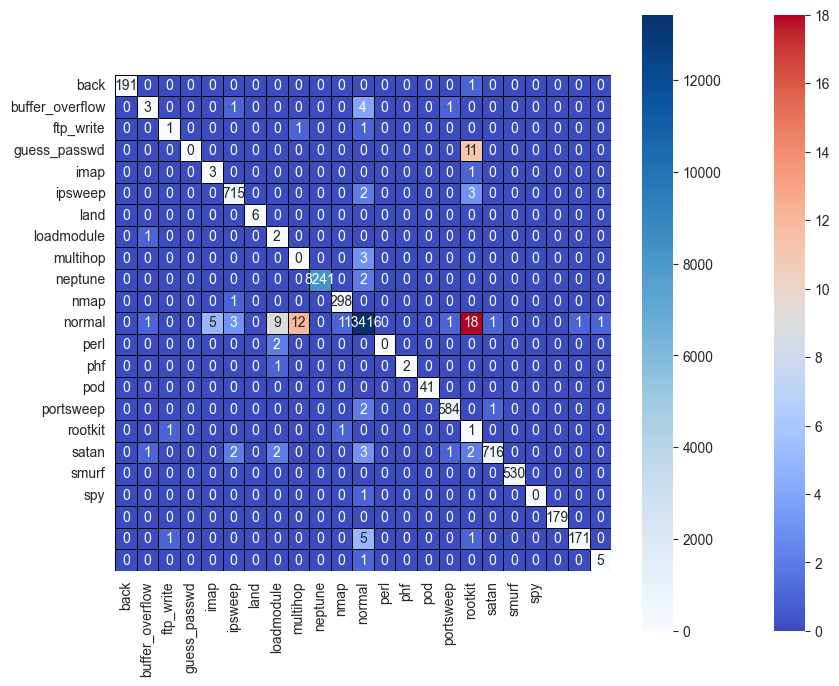

In [33]:
from sklearn.metrics import confusion_matrix

cmgbc = confusion_matrix(y_test_encoded, y_pred_gbc)


cmap = sns.color_palette("coolwarm", as_cmap=True)
mask = np.eye(cmgbc.shape[0], dtype=bool)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cmgbc, annot=True, fmt='d', cmap=cmap, cbar=True, square=True, mask=mask, 
            linecolor='black', linewidth=0.5,
            xticklabels=target_classes, yticklabels=target_classes)  # Mask diagonal elements to hide them

# Highlight off-diagonal values (you can choose a specific color for the off-diagonal)
sns.heatmap(cmgbc, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            mask=~mask, linecolor='black', linewidth=0.5,
            xticklabels=target_classes[0:-3], yticklabels=target_classes[0:-3]) 

In [36]:
print(classification_report(y_test_encoded,y_pred_gbc,target_names=target_classes))

                 precision    recall  f1-score   support

           back       1.00      0.99      1.00       192
buffer_overflow       0.50      0.33      0.40         9
      ftp_write       0.33      0.33      0.33         3
   guess_passwd       0.00      0.00      0.00        11
           imap       0.38      0.75      0.50         4
        ipsweep       0.99      0.99      0.99       720
           land       1.00      1.00      1.00         6
     loadmodule       0.12      0.67      0.21         3
       multihop       0.00      0.00      0.00         3
        neptune       1.00      1.00      1.00      8243
           nmap       0.99      1.00      0.99       299
         normal       1.00      1.00      1.00     13469
           perl       0.00      0.00      0.00         2
            phf       1.00      0.67      0.80         3
            pod       1.00      1.00      1.00        41
      portsweep       0.99      0.99      0.99       587
        rootkit       0.03    

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [37]:
params = {
    "n_estimators": [50,100,150,200],
    "max_depth" : [3, 4, 5, 7],
    "max_leaf_nodes" : [20, 40, 80],
    "learning_rate": [0.1, 0.2, 0.3]
}

gbc = GradientBoostingClassifier(random_state=42, loss = 'log_loss')

random_search_gbc = RandomizedSearchCV(gbc, param_distributions=params, 
                                   n_iter=200, cv=5, scoring='accuracy', 
                                   n_jobs=-1, random_state=42)
random_search_gbc.fit(X_train_smote, y_train_smote)
random_search_gbc.best_params_

d:\Scaler\end_to_end\Donor_Choose\project\lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 144 is smaller than n_iter=200. Running 144 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


KeyboardInterrupt: 